# About Dataset

Features:
fraud_bool (boolean) = (1 if fraud, 0 if legit).

income (numeric) = Annual income of the applicant in quantiles. Ranges between [0, 1].

name_email_similarity (numeric) = Metric of similarity between email and applicant’s name. Higher values represent higher similarity. Ranges

prev_address_months_count (numeric) = Number of months in previous registered address of the applicant, i.e. the applicant’s previous residence, if applicable. Ranges between [-1, 380] months (-1 is a missing value).

current_address_months_count (numeric) = Months in currently registered address of the applicant. Ranges between [-1, 429] months (-1 is a missing value).

customer_age (numeric) = Applicant’s age in bins per decade (e.g, 20-29 is represented as 20). Ranges between [10, 90] years.

days_since_request (numeric): Number of days passed since application was done. Ranges between [0, 79] days.

intended_balcon_amount (numeric): Initial transferred amount for application. Ranges between [–16, 114] (negatives are missing values).

payment_type (categorical): Credit payment plan type. 5 possible (anonymized) values.

zip_count_4w (numeric): Number of applications within same zip code in last 4 weeks. Ranges between [1, 6830].

velocity_6h (numeric): Velocity of total applications made in last 6 hours i.e., average number of applications per hour in the last 6 hours. Ranges between [–175, 16818].

velocity_24h (numeric): Velocity of total applications made in last 24 hours i.e., average number of applications per hour in the last 24 hours. Ranges between [1297, 9586].

velocity_4w (numeric): Velocity of total applications made in last 4 weeks i.e., average number of applications per hour in the last 4 weeks. Ranges between [2825, 7020].

bank_branch_count_8w (numeric): Number of total applications in the selected bank branch in last 8 weeks. Ranges between [0, 2404].

date_of_birth_distinct_emails_4w (numeric): Number of emails for applicants with same date of birth in last 4 weeks. Ranges between [0, 39].

employment_status (categorical): Employment status of the applicant. 7 possible (anonymized) values.

credit_risk_score (numeric): Internal score of application risk. Ranges between [–191, 389].

email_is_free (binary): Domain of application email (either free or paid).

housing_status (categorical): Current residential status for applicant. 7 possible (anonymized) values.

phone_home_valid (binary): Validity of provided home phone.

phone_mobile_valid (binary): Validity of provided mobile phone.

bank_months_count (numeric): How old is previous account (if held) in months. Ranges between [–1, 32] months (–1 is a missing value).

has_other_cards (binary): If applicant has other cards from the same banking company.

proposed_credit_limit (numeric): Applicant’s proposed credit limit. Ranges between [200, 2000].

foreign_request (binary): If origin country of request is different from bank’s country.

source (categorical): Online source of application. Either browser (INTERNET) or app (TELEAPP).

session_length_in_minutes (numeric): Length of user session in banking website in minutes. Ranges between [–1, 107] minutes (–1 is a missing value).

device_os (categorical): Operative system of device that made request. Possible values are: Windows, macOS, Linux, X11, or other.

keep_alive_session (binary): User option on session logout.

device_distinct_emails (numeric): Number of distinct emails in banking website from the used device in last 8 weeks. Ranges between [–1, 2] emails (–1 is a missing value).

device_fraud_count (numeric): Number of fraudulent applications with used device. Ranges between [0, 1].

month (numeric): Month where the application was made. Ranges between [0, 7].

Link dataset: https://www.kaggle.com/datasets/sgpjesus/bank-account-fraud-dataset-neurips-2022

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load Dataset

In [2]:
data = pd.read_csv("/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv")
data

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,0,0.8,0.124690,-1,143,30,0.051348,-0.826239,AB,530,...,0,1500.0,0,INTERNET,16.967770,other,0,1,0,7
999996,0,0.9,0.824544,-1,193,30,0.009591,0.008307,AC,408,...,1,1000.0,0,INTERNET,1.504109,macintosh,0,1,0,7
999997,0,0.8,0.140891,-1,202,10,0.059287,50.609995,AA,749,...,0,200.0,0,INTERNET,16.068595,other,0,1,0,7
999998,0,0.9,0.002480,52,3,30,0.023357,-1.313387,AB,707,...,0,200.0,0,INTERNET,1.378683,linux,1,1,0,7


# Data Understanding

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_24h                      1000

In [35]:
data.describe()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,zip_count_4w,velocity_6h,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,16.718568,86.587867,33.689080,1.025705e+00,8.661499,1572.692049,5665.296605,...,0.889676,10.839303,0.222988,515.851010,0.025242,7.544940,0.576947,1.018312,0.0,3.288674
std,0.104438,0.290343,0.289125,44.046230,88.406599,12.025799,5.381835e+00,20.236155,1005.374565,3009.380665,...,0.313293,12.116875,0.416251,487.559902,0.156859,8.033106,0.494044,0.180761,0.0,2.209994
min,0.000000,0.100000,0.000001,-1.000000,-1.000000,10.000000,4.036860e-09,-15.530555,1.000000,-170.603072,...,0.000000,-1.000000,0.000000,190.000000,0.000000,-1.000000,0.000000,-1.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,-1.000000,19.000000,20.000000,7.193246e-03,-1.181488,894.000000,3436.365848,...,1.000000,-1.000000,0.000000,200.000000,0.000000,3.103053,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,-1.000000,52.000000,30.000000,1.517574e-02,-0.830507,1263.000000,5319.769349,...,1.000000,5.000000,0.000000,200.000000,0.000000,5.114321,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,12.000000,130.000000,40.000000,2.633069e-02,4.984176,1944.000000,7680.717827,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,383.000000,428.000000,90.000000,7.845690e+01,112.956928,6700.000000,16715.565404,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


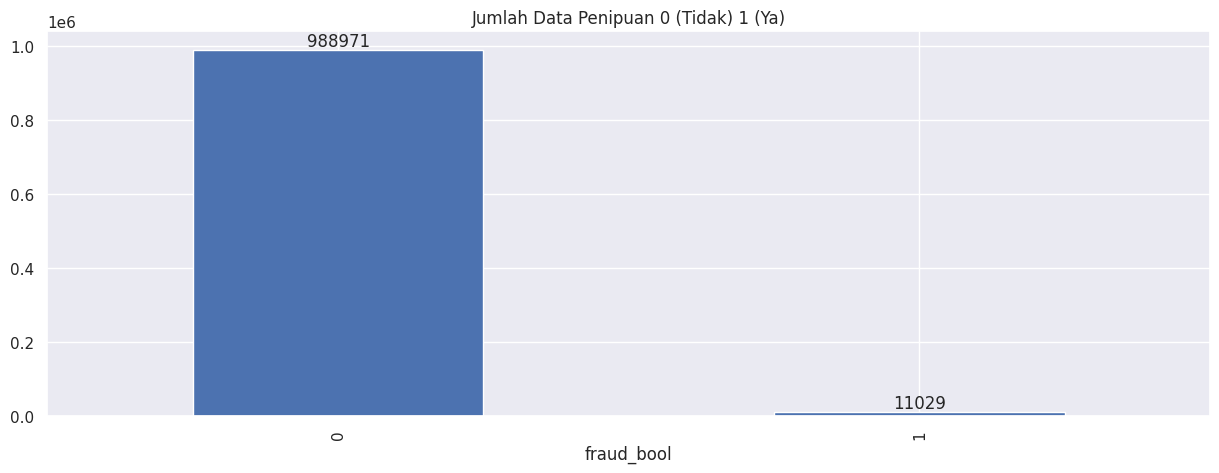

In [75]:
plot = data["fraud_bool"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Data Penipuan 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

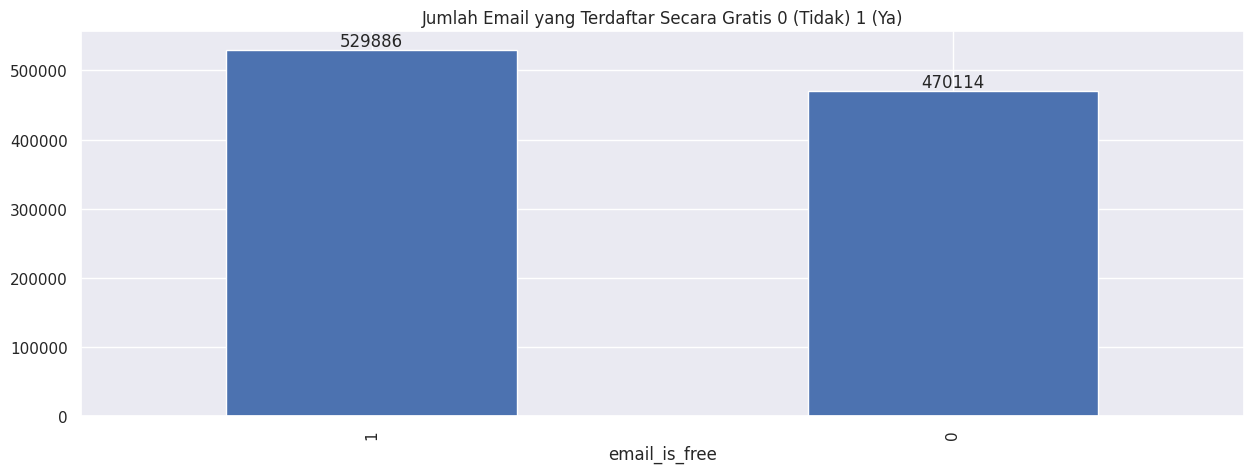

In [74]:
plot = data["email_is_free"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Email yang Terdaftar Secara Gratis 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

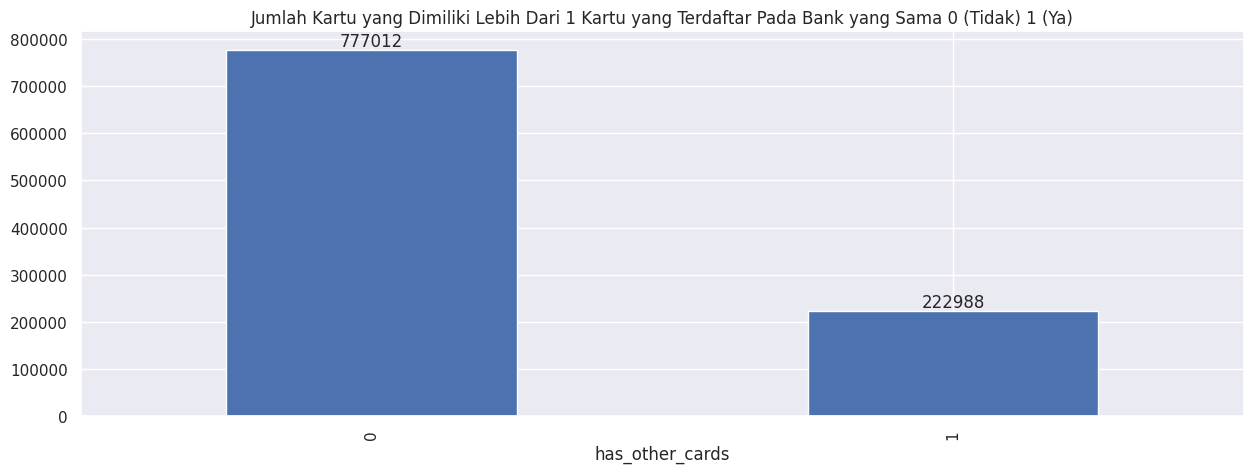

In [73]:
plot = data["has_other_cards"].value_counts()
ax = plot.plot.bar(figsize=(15, 5))
ax.set_title("Jumlah Kartu yang Dimiliki Lebih Dari 1 Kartu yang Terdaftar Pada Bank yang Sama 0 (Tidak) 1 (Ya)")

for container in ax.containers:
    ax.bar_label(container)

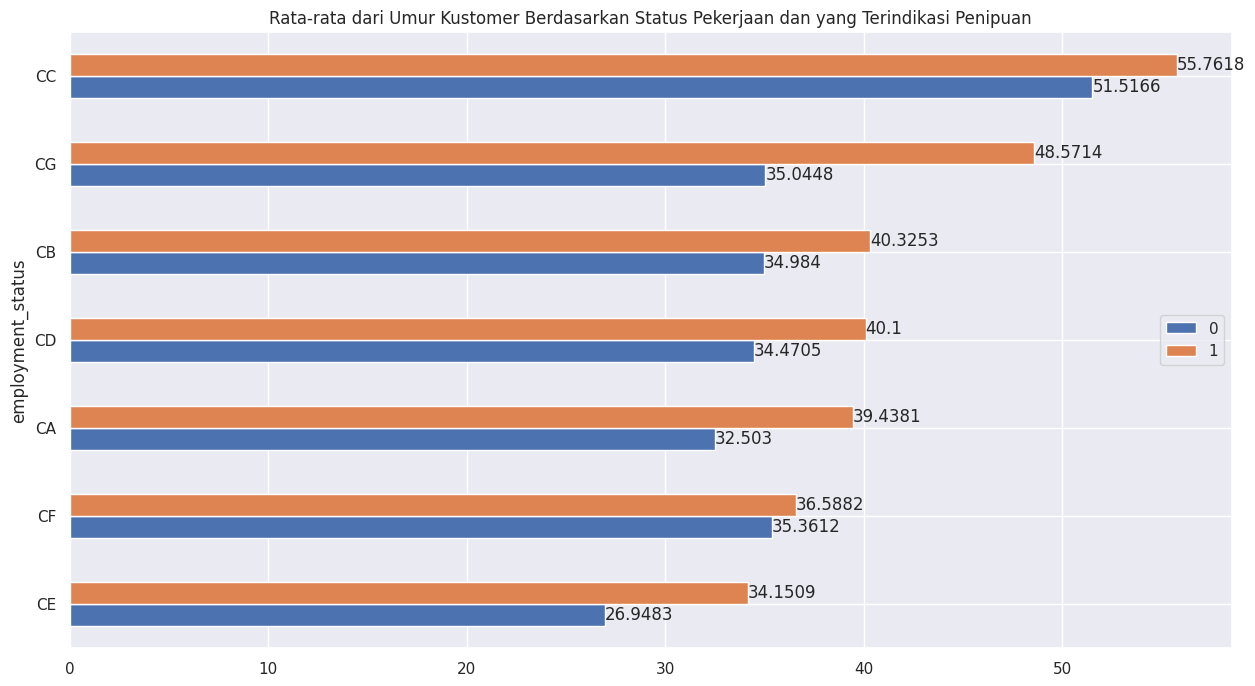

In [42]:
# Mengurutkan berdasarkan fitur fraud_bool 1
plot = data.groupby(["employment_status", "fraud_bool"])["customer_age"].mean().unstack().sort_values(by=1, ascending=True)
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Rata-rata dari Umur Kustomer Berdasarkan Status Pekerjaan dan yang Terindikasi Penipuan")
ax.legend(loc="center right")

for container in ax.containers:
    ax.bar_label(container)

In [10]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns

In [19]:
def print_categories_features(data):
    for col in categorical_features:
        plt.figure(figsize=(8, 5))
        counts = data[col].value_counts(dropna=False)
        counts.plot(kind='bar')
        plt.title(f'Distribusi Kategori: {col}')
        plt.xlabel(col)
        plt.ylabel('Jumlah')
        plt.xticks(rotation=45, ha='right')
        
        # Tambahkan nilai di atas setiap batang
        for i, count in enumerate(counts):
            plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=9)
            
        plt.tight_layout()
        plt.show()

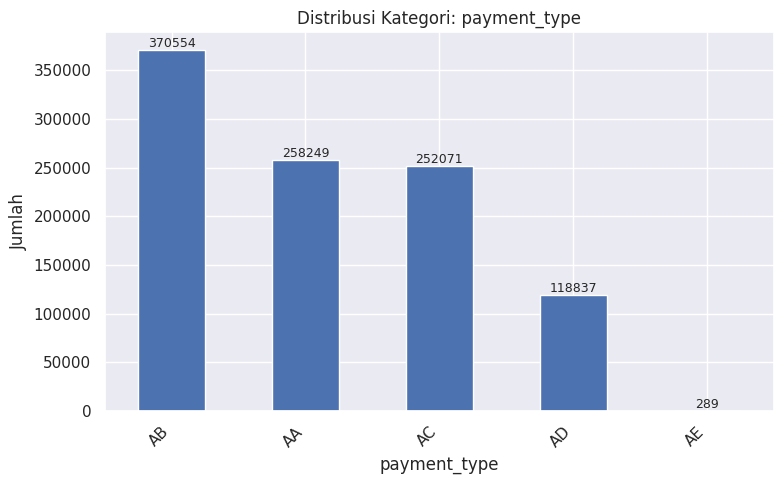

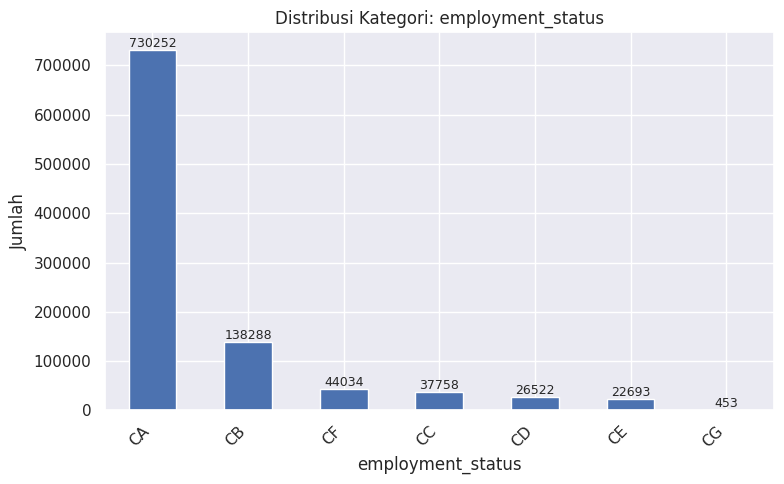

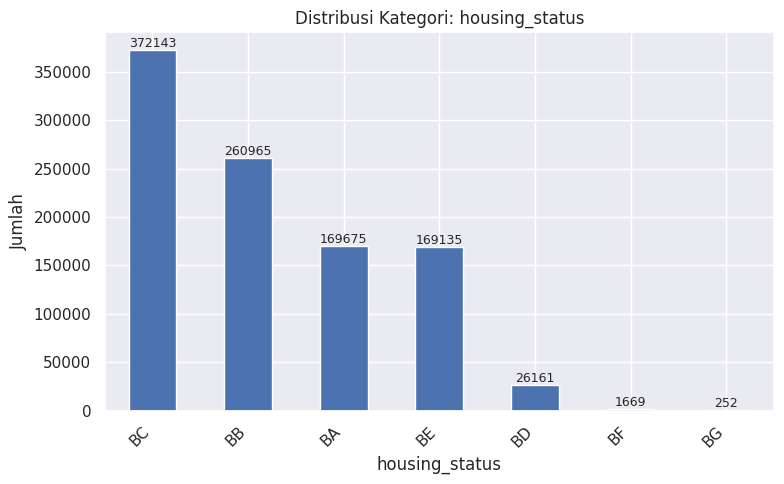

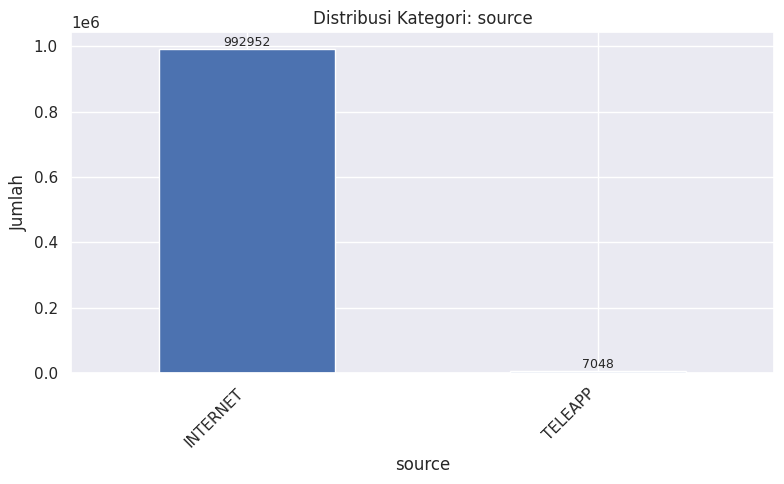

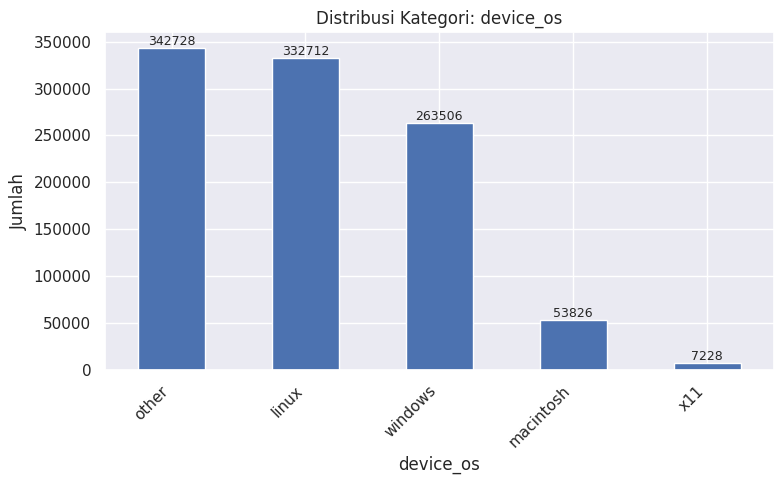

In [20]:
print_categories_features(data)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

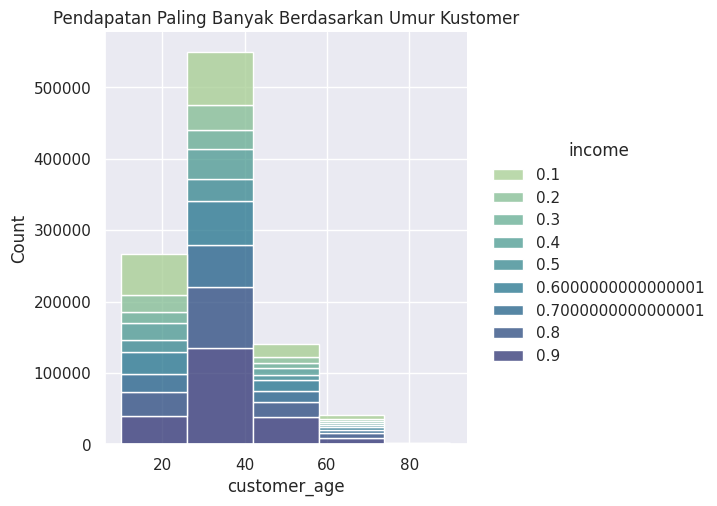

In [34]:
sns.displot(
    data=data, 
    bins=5, 
    x="customer_age", 
    hue="income", 
    multiple="stack", 
    palette="crest").set(title="Pendapatan Paling Banyak Berdasarkan Umur Kustomer");

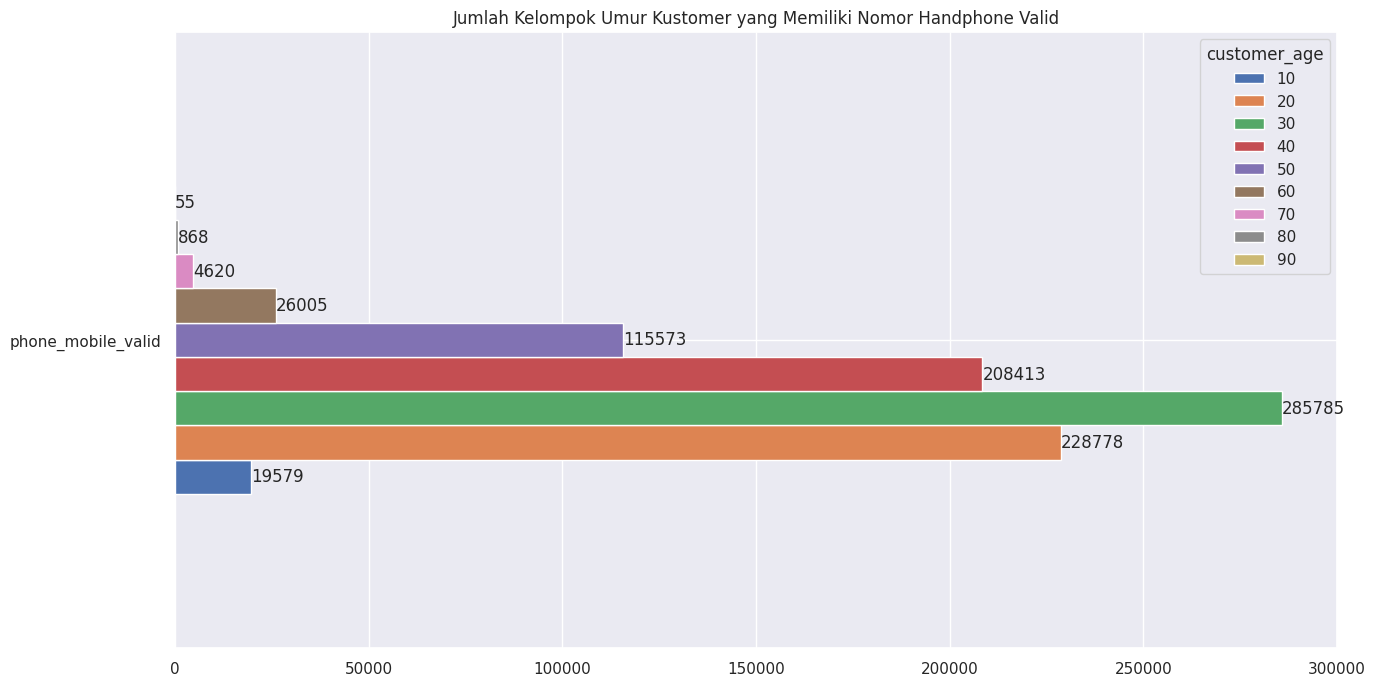

In [47]:
plot = pd.pivot_table(data=data, values="phone_mobile_valid", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Memiliki Nomor Handphone Valid")

for container in ax.containers:
    ax.bar_label(container)

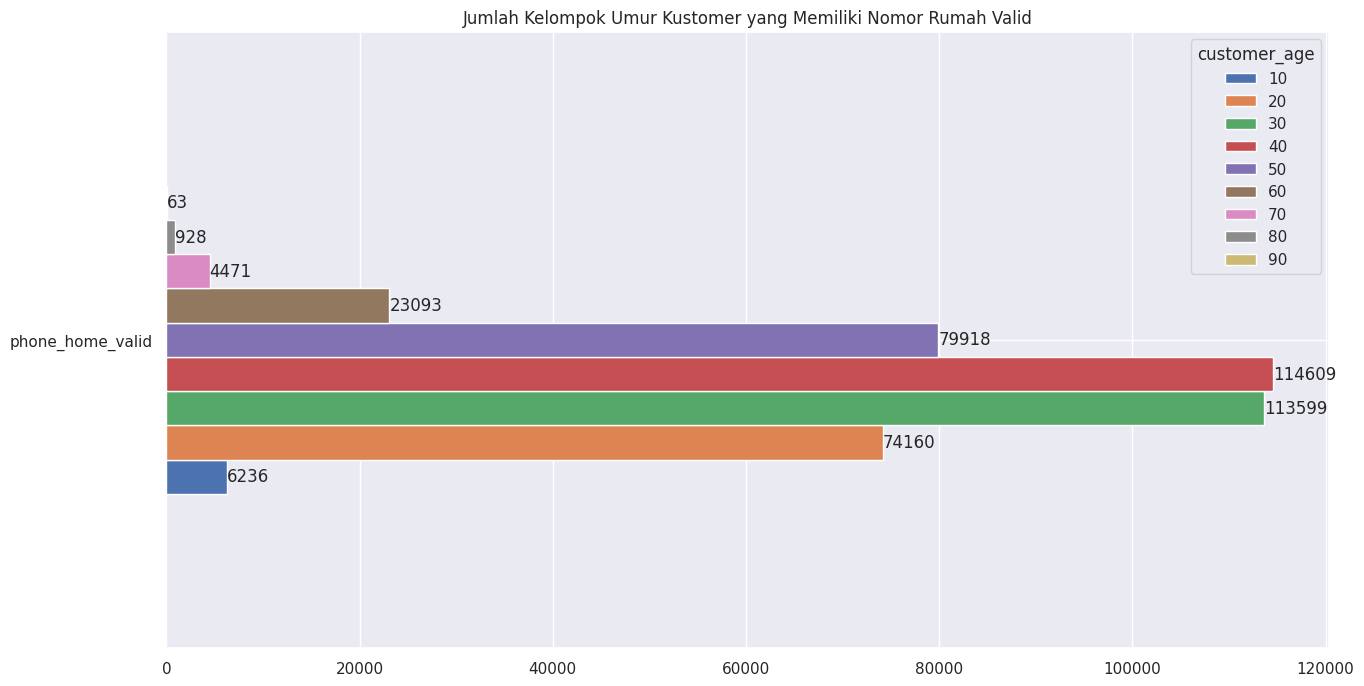

In [52]:
plot = pd.pivot_table(data=data, values="phone_home_valid", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Memiliki Nomor Rumah Valid")

for container in ax.containers:
    ax.bar_label(container)

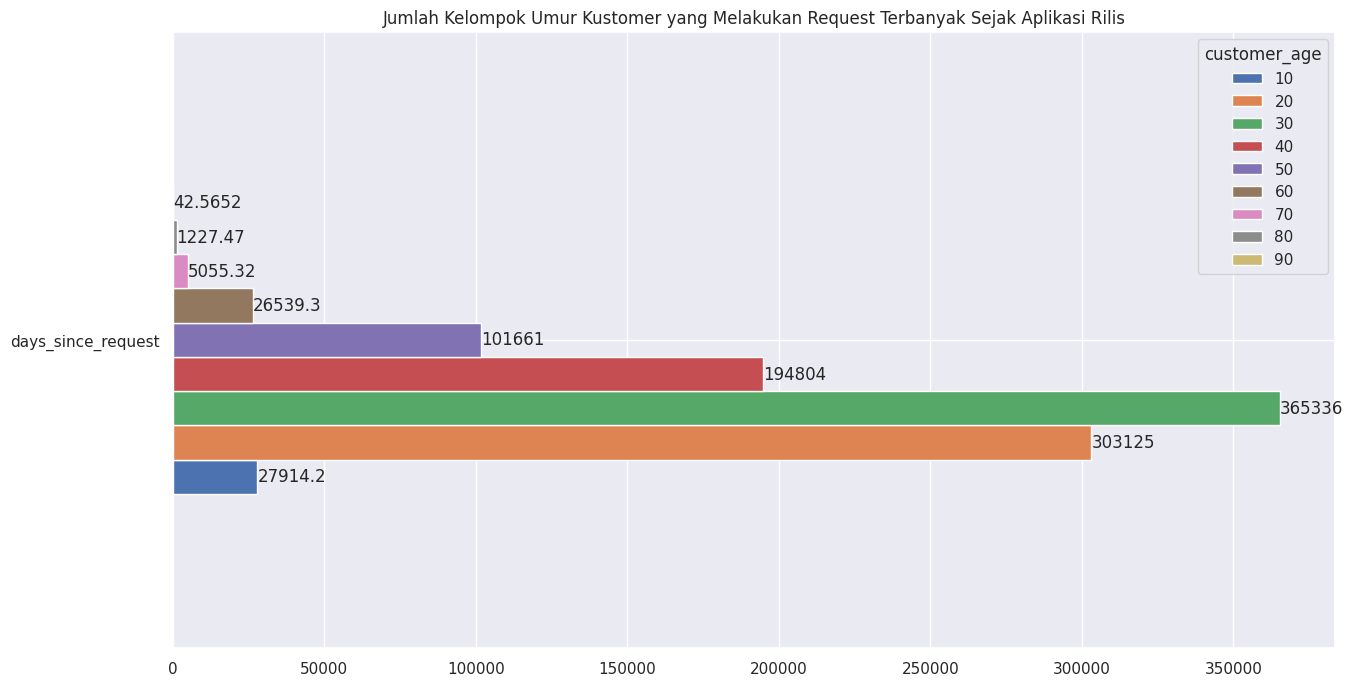

In [53]:
plot = pd.pivot_table(data=data, values="days_since_request", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Kelompok Umur Kustomer yang Melakukan Request Terbanyak Sejak Aplikasi Rilis")

for container in ax.containers:
    ax.bar_label(container)

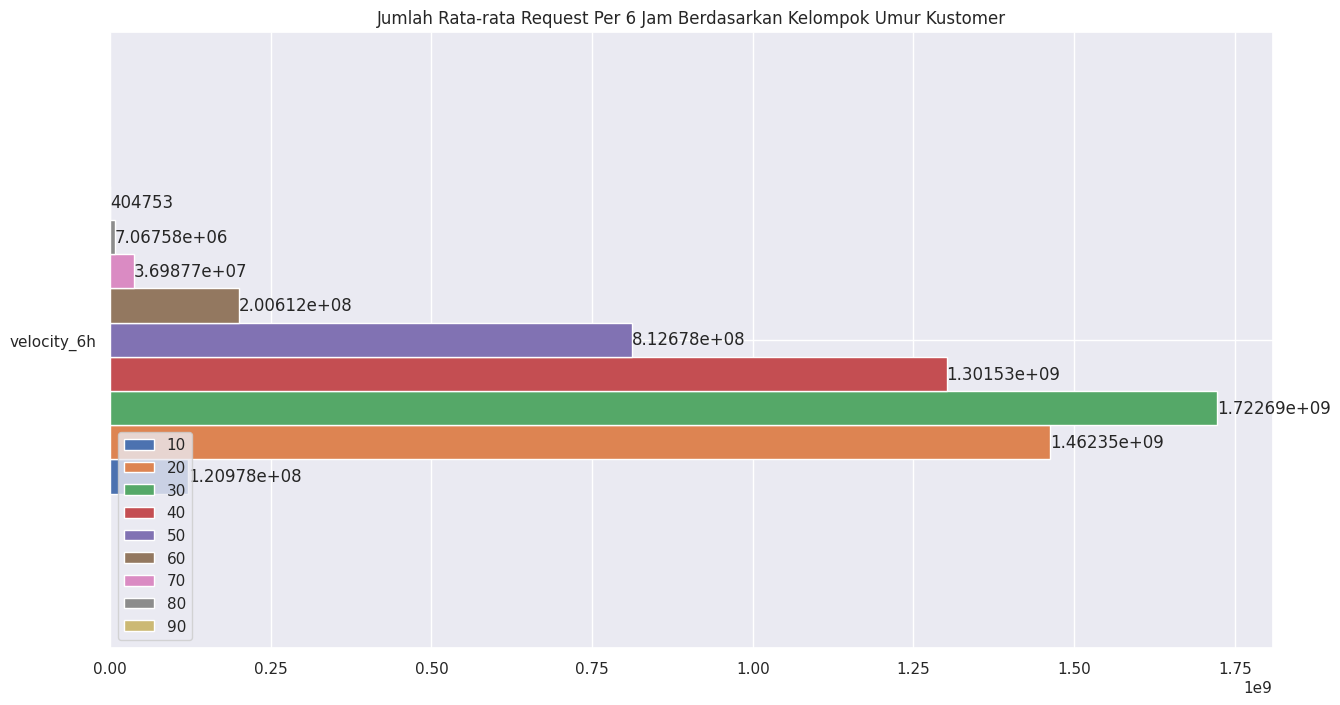

In [64]:
plot = pd.pivot_table(data=data, values="velocity_6h", columns="customer_age", aggfunc="sum")
ax = plot.plot.barh(figsize=(15, 8))
ax.set_title("Jumlah Rata-rata Request Per 6 Jam Berdasarkan Kelompok Umur Kustomer")
ax.legend(loc="lower left")

for container in ax.containers:
    ax.bar_label(container)